In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, kstest
from scipy import stats
import statsmodels.api as sm
from arch.univariate import arch_model
from arch.unitroot import ADF
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox

## Preparation
- Calculate the log returns $(r_t)_{t \geq 0}$ and linearised losses $l_t = -r_t$, where
$$
r_t = (\log(S_t) - \log(S_{t-1})) \times 100
$$
- Split the datasheet into training and test set, with a split date of 26 Nov, 2021.


In [2]:
df = pd.read_csv('./QRM-2025-cw2-data.csv')
df_nodelay = df['TSLA']
df_delay = df['TSLA'].shift(1)
df['log_return'] = (np.log(df_nodelay) - np.log(df_delay)) * 100
df['linearised_loss'] = -df['log_return']
df['Date'] = pd.to_datetime(df['Date'])
cutoff = pd.Timestamp('2021-11-26')
train_df = df.loc[df['Date'] < cutoff]   # prior to 26 Nov 2021
test_df  = df.loc[df['Date'] >= cutoff]

In [3]:
print(df.head())

        Date      TSLA  log_return  linearised_loss
0 2012-11-26  2.151333         NaN              NaN
1 2012-11-27  2.143333   -0.372556         0.372556
2 2012-11-28  2.215333    3.304064        -3.304064
3 2012-11-29  2.246000    1.374813        -1.374813
4 2012-11-30  2.254667    0.385143        -0.385143


In [4]:
train_df.tail()

,Date,TSLA,log_return,linearised_loss
2262,2021-11-18,365.459991,0.674481,-0.674481
2263,2021-11-19,379.019989,3.643214,-3.643214
2264,2021-11-22,385.623322,1.727210,-1.727210
2265,2021-11-23,369.676666,-4.223230,4.223230
2266,2021-11-24,372.000000,0.626511,-0.626511


In [5]:
test_df.head()

,Date,TSLA,log_return,linearised_loss
2267,2021-11-26,360.640015,-3.101358,3.101358
2268,2021-11-29,378.996674,4.964716,-4.964716
2269,2021-11-30,381.586670,0.681058,-0.681058
2270,2021-12-01,365.000000,-4.444065,4.444065
2271,2021-12-02,361.533325,-0.954313,0.954313


## Part (i): Fit a standard GARCH(1,1) model

In this part, we are going to fit a standard GARCH(1,1) model with constant conditional mean and innovations $N(0,1)$ on the **training set only**.

In [6]:
#Fit the GARCH(1,1) model to the linearised loss
norm_am = arch_model(train_df['linearised_loss'].dropna(), mean="Constant", vol="GARCH", p=1, q=1, dist="normal")
norm_res = norm_am.fit(update_freq=0, disp="off")
norm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:        linearised_loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Tue, Dec 02 2025   Df Residuals:                     2265
Time:                        18:06:44   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.891e-02 [ -0.276,-2.485e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1390  7.816e-02      1.779  7.532e-02  [-1.418e-02,  0.292]
alpha[1]       0.0409  1.327e-02      3.085  2.033e-03 [1.493e-02,6.695e-02]
beta[1]        0.9482  1.768e-02     53.644      0.000     [  0.914,  0.983]
============================================================================

Covariance estimator: robust
"""

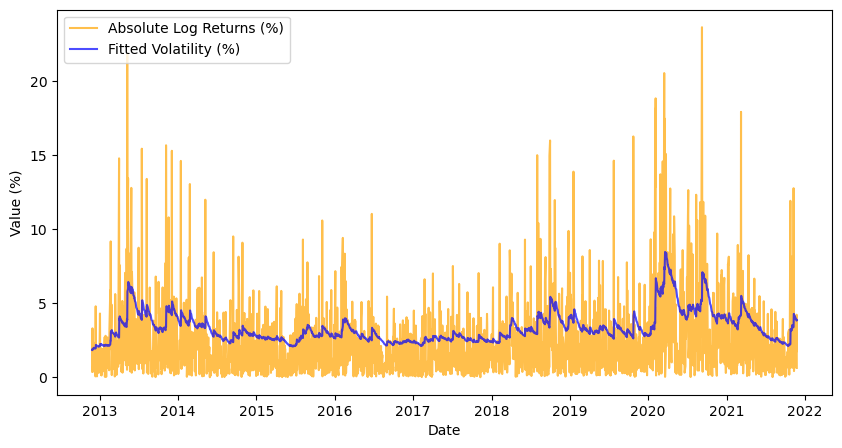

In [7]:
train_df2 = train_df.dropna(subset=['linearised_loss']).copy()
abs_train_df2 = train_df2['linearised_loss'].abs()
#obtain the fitted conditional volatility in training data
norm_vol = pd.Series(norm_res.conditional_volatility, index=train_df2.index)
dates = train_df2['Date']

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, abs_train_df2, label='Absolute Log Returns (%)', alpha=0.7, color = 'orange')
ax.plot(dates, norm_vol, label='Fitted Volatility (%)', linewidth=1.5, alpha=0.7, color = 'blue')
ax.set_xlabel('Date')
ax.set_ylabel('Value (%)')
ax.legend(loc = "upper left")
plt.savefig('Assets/Part_i_fitted_figure')
plt.show()

In [8]:
norm_std_resid = norm_res.std_resid

In [9]:
#Test for Independence and correlation of standardised Residual

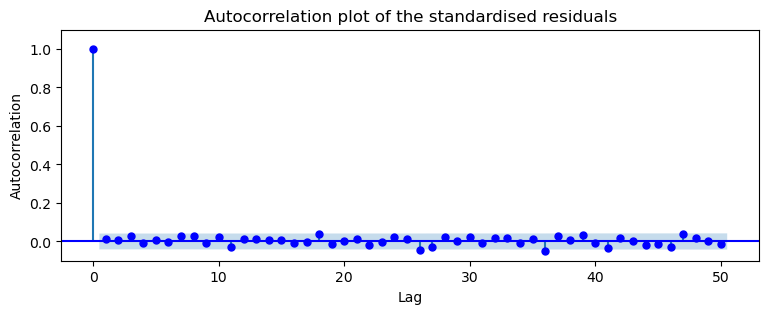

In [10]:
fig, ax = plt.subplots(figsize=(9, 3))
sm.graphics.tsa.plot_acf(
    norm_std_resid.dropna(),
    lags=50,
    ax=ax,
    color="blue",
)
ax.set_title("")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_ylim(-0.1, 1.1)
ax.set_title('Autocorrelation plot of the standardised residuals')
plt.savefig('Assets/Part_i_autocor_std_res.png')
plt.show()

Ljung Box test statistics $Q$ is used to determine the correlation of the standardised residual
$$
Q = T(T+2)\sum_{k=1}^{h} 
\frac{\hat{\rho}_k^{\,2}}{T-k}, \quad \text{where} \ T \ \text{is number of observations}
$$

$$
Q \sim \chi^{2}_{h}
\quad \text{under } H_{0} \text{ (no autocorrelation)}.
$$


In [11]:
#Implemetationo of Ljung Box test for standardised residual autocorrelation
lb_stat, lb_pvalue = acorr_ljungbox(norm_std_resid, lags=20, return_df=False)
#Return the statistics and p-value as pd data frame
results = pd.DataFrame({
    "Lag": range(1, 21),
    "Statistic": lb_stat,
    "p-value": lb_pvalue
}).T

print(results)

                 0         1         2         3         4         5   \
Lag        1.000000  2.000000  3.000000  4.000000  5.000000  6.000000   
Statistic  0.434716  0.560370  2.103605  2.354117  2.562035  2.595451   
p-value    0.509684  0.755644  0.551184  0.670934  0.767125  0.857636   

                 6         7         8          9          10         11  \
Lag        7.000000  8.000000  9.000000  10.000000  11.000000  12.000000   
Statistic  4.319956  6.115569  6.214529   7.269515   9.029075   9.569428   
p-value    0.742275  0.634288  0.718270   0.699780   0.619208   0.653677   

                  12         13         14         15         16         17  \
Lag        13.000000  14.000000  15.000000  16.000000  17.000000  18.000000   
Statistic  10.016155  10.209935  10.386157  10.496402  10.551484  14.017509   
p-value     0.692613   0.746679   0.794772   0.839453   0.878908   0.727949   

                  18         19  
Lag        19.000000  20.000000  
Statistic  14.449

The p-value for all lags less than 20 has p-value higher than 0.5, there is insufficient statistical evidence to reject the assumption that the standardised residual ate uncorrelated.

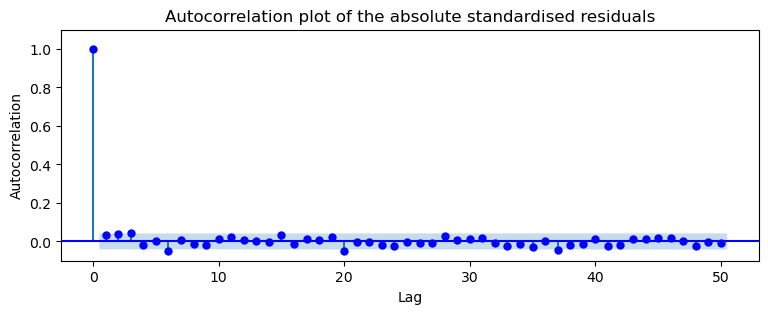

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))
sm.graphics.tsa.plot_acf(
    np.abs(norm_std_resid).dropna(),
    lags=50,
    ax=ax,
    color="blue",
)
ax.set_title("")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation plot of the absolute standardised residuals")
ax.set_ylim(-0.1, 1.1)
plt.savefig('Assets/Part_i_autocor_abs_std_res.png')
plt.show()

We let $\hat{Z}_t$ be the standardised residual and we regress on the following equation
$$
\hat{Z}_t^{2}
=
\alpha_{0}
+
\sum_{i=1}^{q} \alpha_{i} \hat{Z}_{t-i}^{2}
+
\epsilon_t 
$$
The test statistics under $H_{0}$ where $\alpha_{1}=...=\alpha_{q}=0$ is:
$$
\text{LM} = T R^{2}\ \sim \chi^{2}_{q},\quad \text{where} \ T \ \text{is number of observations}
$$

In [13]:
#Implemetationo of ARCH-LM test for ARCH type effect
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(norm_std_resid, nlags=50)
print("ARCH-LM statistic:", lm_stat)
print("p-value:", lm_pvalue)

ARCH-LM statistic: 54.23400400518101
p-value: 0.31622546207055496


The p-value of the ARCH-LM test is 0.316, we have insufficient evidence to reject $H_0$ that residuals do not have ARCH effect

In [14]:
#Test for Distribution of standardised Residual

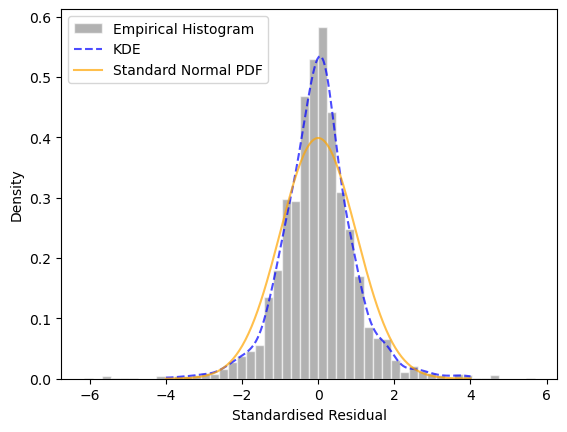

In [15]:
x = np.linspace(-4, 4, 200)
plt.hist(norm_std_resid, bins=50, density=True, color='gray', 
         alpha=0.6, edgecolor='white', label='Empirical Histogram')
kde = stats.gaussian_kde(norm_std_resid.dropna())
plt.plot(x, kde(x), color="blue", alpha=0.7, linestyle="--", label='KDE')
plt.plot(x, stats.norm.pdf(x), color="orange", alpha=0.7, label='Standard Normal PDF')
plt.xlabel('Standardised Residual')
plt.ylabel('Density')
plt.legend(loc="upper left")
plt.savefig('Assets/Part_i_kde.png')
plt.show()

Plotting the historgram of the standardised residuals and comparing the KDE with the density of standard normal distribution, the standardised residuals does not look like an iid sample from the standard normal distribution (which is $F_{Z}$). This suggest that the process might not be correctly specified.

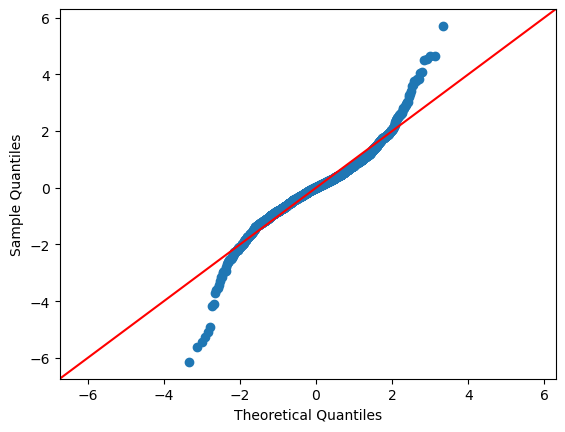

In [16]:
#QQ plot for distribution of standardised residuals against normal distribution
sm.qqplot(norm_std_resid, line='45', fit=True)
plt.savefig('Assets/Part_i_qqplot.png')
plt.show()

From the QQ plot above, the sample quantiles are significantly lower for the left tail while the quantiles are obviously higher for the right tail, signalling excess kurtosis and fat tail property of the standardised residual, confirming with the Histogram above.
Then we did Anderson-Darling test for distribution, the statistics $A$ is defined below
$$
A^{2}=-n-\frac{1}{n}\sum_{i=1}^{n}(2i - 1)
\left[\ln F(X_{(i)}) + \ln\!\left(1 - F(X_{(n+1-i)})\right)\right],
$$


In [17]:
#Implemetationo of Anderson-Darling test for distribution test
norm_ad_res = stats.anderson(norm_std_resid, dist = 'norm')
print(f'Anderson-Darling test:\n'
      f'statistic = {norm_ad_res.statistic:.1f}\n'
      f'critical value with significance level 1% = {norm_ad_res.critical_values[-1]:.2f}\n')

Anderson-Darling test:
statistic = 21.7
critical value with significance level 1% = 1.09



The QQ-plot and the result of the Anderson-Darling test provide stronger evidence that we should reject our null hypothesis that the standardised reusdials are i.i.d. standard normal samples.

## Part (ii): Fit a normalised Student-$t$ distribution to the standardised residuals

In [18]:
from scipy.optimize import minimize
from scipy.special import gammaln

def negloglik_unitvar_t(nu, data):
    if nu <= 2.01: #This is the case where variance is infinite
        return 1e12
    s = np.sqrt((nu - 2.0) / nu)
    dist = t(df=nu, loc=0.0, scale=s)
    # return negative log-likelihood of data
    return -np.sum(dist.logpdf(data))
#minimise negative log-likelihood using L-BFGS-B
res = minimize(lambda x: negloglik_unitvar_t(x[0], np.asarray(norm_std_resid)),
               x0=[6.0], bounds=[(2.01, 200.0)], method='L-BFGS-B')
nu_hat = float(res.x[0])
s_hat  = np.sqrt((nu_hat - 2.0) / nu_hat)

D_t, p_t = kstest(norm_std_resid, 't', args=(nu_hat, 0.0, s_hat))
print(f"KS vs unit-Var t: D={D_t:.4f}, p-value={p_t:.4f}")
print(f"Estimated degrees of freedom (nu) = {nu_hat:.4f}")
print(f"Scale for unit variance = {s_hat:.4f}")

KS vs unit-Var t: D=0.0188, p-value=0.3934
Estimated degrees of freedom (nu) = 3.8000
Scale for unit variance = 0.6882


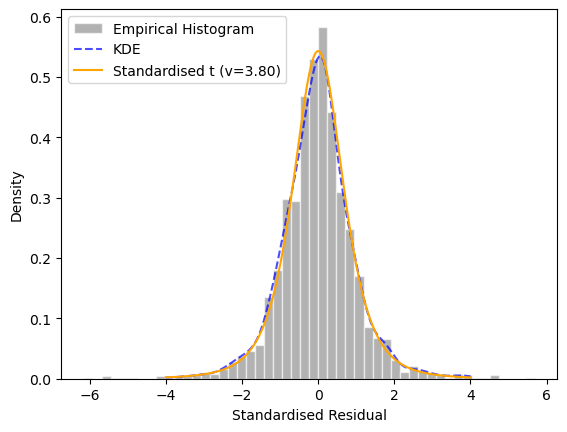

In [19]:
x = np.linspace(-4, 4, 200)
plt.hist(norm_std_resid, bins=50, density=True, color='gray', 
         alpha=0.6, edgecolor='white', label='Empirical Histogram')
kde = stats.gaussian_kde(norm_std_resid.dropna())
plt.plot(x, kde(x), color="blue", alpha=0.7, linestyle="--", label='KDE')
plt.plot(x, t.pdf(x, df=nu_hat, loc=0, scale=s_hat), color='orange', 
         label=f'Standardised t (v={nu_hat:.2f})')
plt.xlabel('Standardised Residual')
plt.ylabel('Density')
plt.legend(loc = "upper left")
plt.savefig('Assets/Part_ii_kde.png')
plt.show()

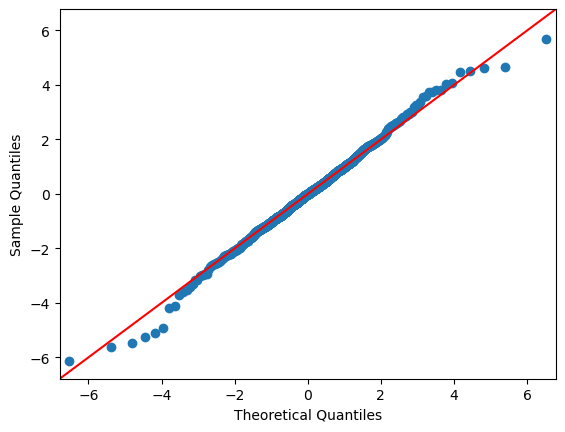

In [20]:
sm.qqplot(norm_std_resid, dist=t, distargs=(nu_hat,), loc=0, scale=s_hat, line='45')
plt.savefig('Assets/Part_ii_qqplot.png')
plt.show()

The student-t distribution generally fits the standardised residual well. Compared with the previous results, fitting a Student-$t$ distribution substantially sloves the problem of fat tails, and therefore improves the performance.

In [21]:
D_t, p_t = kstest(norm_std_resid, 't', args=(nu_hat, 0, s_hat))
print(f"KS vs unit-Var t: nu={nu_hat:.4f}, D={D_t:.4f}, p={p_t:.4f}")

KS vs unit-Var t: nu=3.8000, D=0.0188, p=0.3934


For the standardized residuals, the KS test against a unit-variance Student-t gives
- $D=0.0188$,
- $p=0.3934$.

We therefore fail to reject the t ($ν≈3.8$) specification at conventional levels, indicating a reasonable fit. With  $ν=3.8$, the distribution is strongly heavy-tailed.

## Part (iii): Fit a generalised Pareto distribution (GPD) to the standardised residuals

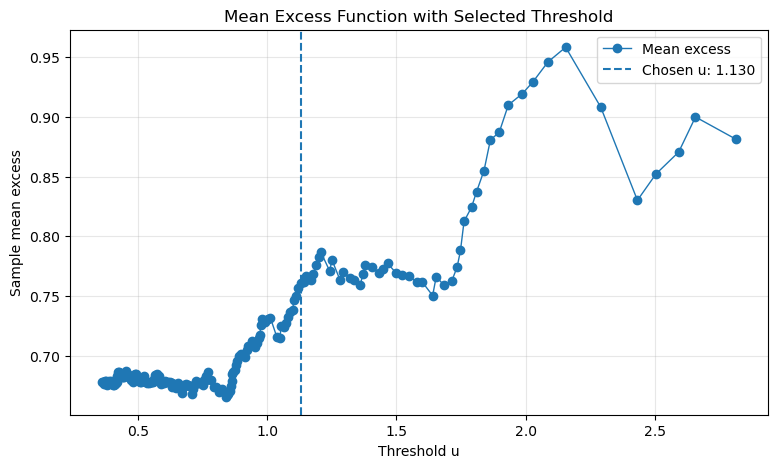

In [22]:
#Mean Excess plot for choosing the value of threshold 
from scipy.stats import genpareto
qs = np.linspace(0.7, 0.99, 180)
#Obtain quantiles from 70% to 99%
us = np.quantile(norm_std_resid, qs)
mean_excess = []
counts = []
for u_val in us:
    #Calculatet the mean excess
    exc = norm_std_resid[norm_std_resid > u_val] - u_val
    mean_excess.append(exc.mean() if exc.size > 0 else np.nan)
    counts.append(exc.size)

u= 1.13
plt.figure(figsize=(9,5))
plt.plot(us, mean_excess, marker="o", lw=1, label="Mean excess")
plt.axvline(u, linestyle="--", label=f"Chosen u: {u:.3f}")
plt.xlabel("Threshold u")
plt.ylabel("Sample mean excess")
plt.title("Mean Excess Function with Selected Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Assets/Part_iii_mean_excess_function_with_thres_selected.png')
plt.show()

From the mean excess function above, the mean excess demonstrates positive linear relationship between $u=1.75$ and $u=1.95$, which suggests the choice of threshold within the region

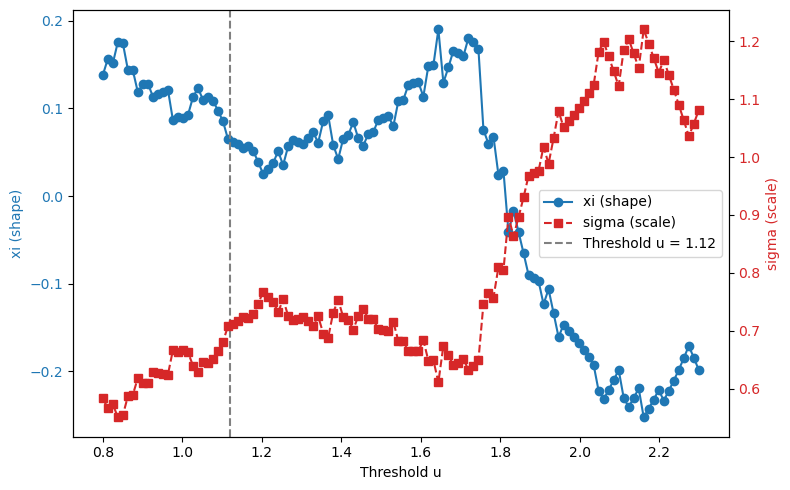

In [23]:
import numpy as np
from scipy.stats import genpareto
import matplotlib.pyplot as plt

data = np.array(norm_std_resid)    # your data
thresholds = np.linspace(0.8, 2.3, 120)   # grid around 1.875
xis, sigmas, n_exceed = [], [], []

for u in thresholds:
    exc = data[data > u] - u
    m = len(exc)
    c, loc, scale = genpareto.fit(exc, floc=0)  # force loc=0, fit c (xi) & scale
    xis.append(c)
    sigmas.append(scale)
    n_exceed.append(m)

fig, ax1 = plt.subplots(figsize=(8,5))

# Plot xi on left axis
l1 = ax1.plot(thresholds, xis, 'o-', color='tab:blue', label='xi (shape)')
ax1.set_xlabel("Threshold u")
ax1.set_ylabel("xi (shape)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for sigma
ax2 = ax1.twinx()
l2 = ax2.plot(thresholds, sigmas, 's--', color='tab:red', label='sigma (scale)')
ax2.set_ylabel("sigma (scale)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

u_star=1.12
# Vertical line at chosen threshold
ax1.axvline(u_star, ls='--', color='gray', label=f"Threshold u = {u_star}")

# Combined legend
lns = l1 + l2
labels = [line.get_label() for line in lns]
labels.append(f"Threshold u = {u_star}")
ax1.legend(lns + [ax1.lines[-1]], labels, loc='right')

plt.tight_layout()
plt.show()


Based on the mean excess plot and stability plots, we select a threshold of $u = 1.5$. While $u=1.875$ showed stability, it leaves too few exceedances for robust estimation. $u=1.5$ provides a balance between bias and variance, resulting in $k=122$ exceedances (approx 10.8% of the positive residuals).

We fit the GPD to the exceedances over $u=1.5$. The results (shown below) yield: $\xi = 0.0894$ (shape) and $\beta = 0.7007$ (scale).

Since $\xi > 0$, the tail distribution is heavy-tailed (Fréchet domain of attraction), which is consistent with financial log-returns. This contrasts with a normal distribution (where $\xi = 0$) or a bounded distribution ($\xi < 0$).

In [24]:
u=1.12
exceedances = norm_std_resid[norm_std_resid > u] - u
k = exceedances.size
n = norm_std_resid.size
exceed_rate = k / n

shape_hat, loc_hat, scale_hat = genpareto.fit(exceedances, floc=0.0)
xi, beta = float(shape_hat), float(scale_hat)

print("=== POT-GPD Fit on Positive Tail ===")
print(f"Chosen threshold u: {u:.4f}")
print(f"Exceedances k: {k} out of n={n} (rate={exceed_rate:.3%})")
print(f"GPD shape xi: {xi:.4f}")
print(f"GPD scale beta: {beta:.4f}")

D, pval = kstest(exceedances, 'genpareto', args=(xi, 0.0, beta))
print(f"KS test on exceedances: D={D:.4f}, p-value={pval:.4f}")

=== POT-GPD Fit on Positive Tail ===
Chosen threshold u: 1.1200
Exceedances k: 203 out of n=2266 (rate=8.959%)
GPD shape xi: 0.0673
GPD scale beta: 0.7051
KS test on exceedances: D=0.0407, p-value=0.8750


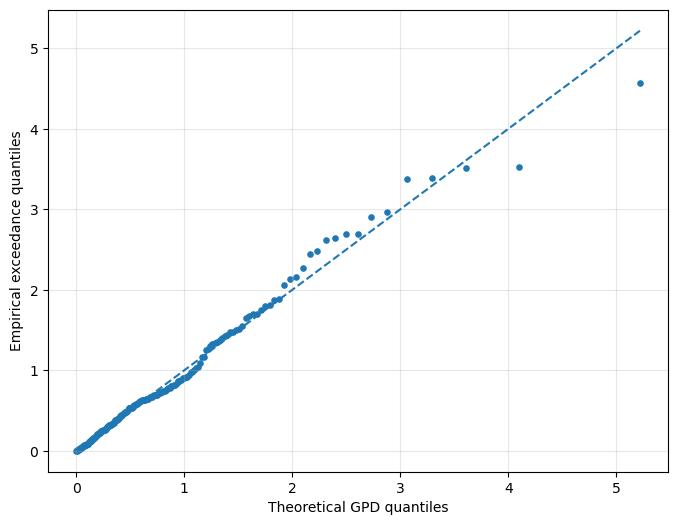

In [25]:
exc_sorted = np.sort(exceedances)
m = exc_sorted.size
if m > 0:
    probs = (np.arange(1, m+1) - 0.5) / m
    theo = genpareto.ppf(probs, c=xi, loc=0.0, scale=beta)
    plt.figure(figsize=(8,6))
    plt.scatter(theo, exc_sorted, s=14)
    mn, mx = float(min(exc_sorted.min(), theo.min())), float(max(exc_sorted.max(), theo.max()))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("Theoretical GPD quantiles")
    plt.ylabel("Empirical exceedance quantiles")
    plt.grid(True, alpha=0.3)
    plt.savefig('Assets/Part_iii_qq_plot_exceedances.png')
    plt.show()

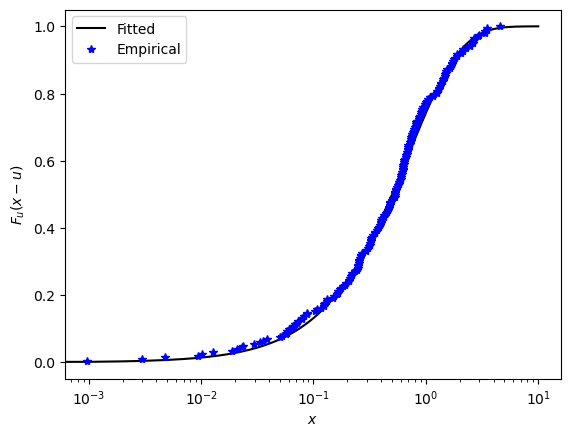

In [26]:
def GPD_cdf(x, xi, beta): # Implement the CDF of GPD
    if xi == 0:
        return 1 - np.exp(-x/beta)
    else:
        return 1 - (1 + xi * x / beta) ** (-1/xi)

xx = np.linspace(0, 10, 10000) # For plotting the theoretical, fitted GPD

# Empirical CDF functionality from the "statsmodels" package
empirical_cdf_obj = sm.distributions.empirical_distribution.ECDF((exceedances.to_numpy()).flatten())

fig, ax = plt.subplots()
ax.plot(xx, GPD_cdf(xx, xi, beta), 'k-', label='Fitted') # Plot the CDF of fitted GPD
ax.plot(exceedances, empirical_cdf_obj(exceedances), 'b*', label='Empirical') # Plot the empirical CDF of Y, the excess claim value above u
ax.legend()
ax.set_xscale('log')
ax.set_ylabel('$F_{u}(x-u)$')
ax.set_xlabel('$x$')
plt.savefig('Assets/Part_iii_cdf_plot_exceedances.png')
plt.show()

GPD shape $\xi$ is the **shape**, which can be used to determine the type of the tail.
GPD scale $\beta$ is the **scale**.

- $\xi = 0$: exponential distribution with rate $\lambda = \frac{1}{\beta}$
- $\xi > 0$: Pareto distribution
- $\xi < 0$: Type-II Pareto distribution


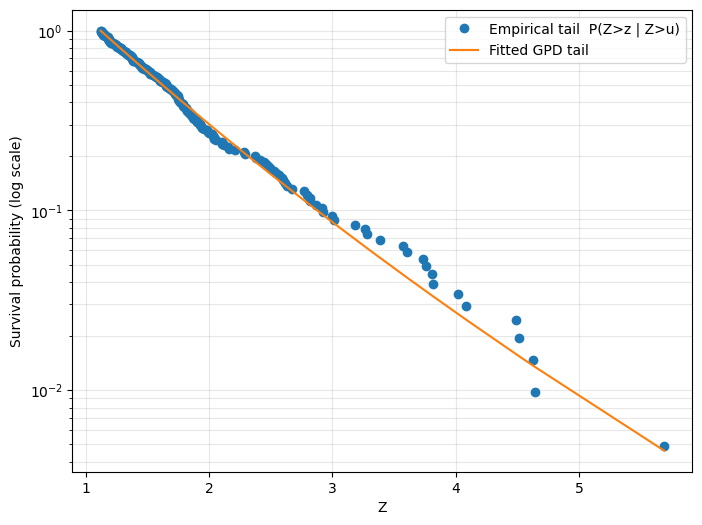

In [27]:
z_tail = norm_std_resid[norm_std_resid > u]
z_tail_sorted = np.sort(z_tail)
m2 = z_tail_sorted.size
if m2 > 0:
    ranks = np.arange(1, m2 + 1)[::-1]
    emp_surv = ranks / (m2 + 1)
    fitted_surv = genpareto.sf(z_tail_sorted - u, c=xi, loc=0.0, scale=beta)

    plt.figure(figsize=(8,6))
    plt.semilogy(z_tail_sorted, emp_surv, "o", label="Empirical tail  P(Z>z | Z>u)")
    plt.semilogy(z_tail_sorted, fitted_surv, "-", label="Fitted GPD tail")
    plt.xlabel("Z")
    plt.ylabel("Survival probability (log scale)")
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.savefig('Assets/Part_iii_tail_survival.png')
    plt.show()

At the chosen threshold $u$, the exceedance QQ plot aligns closely with the $45°$ line, indicating a good GPD fit across the bulk of the tail. The conditional survival plot also matches well in the main region. A few extreme points lie above the fitted curve, suggesting slightly heavier empirical tails at the far.

Overall, the GPD fit is adequate for POT-based VaR/ES.

## Part (iv): VaR and ES forecast on each date in the testing data set

In [28]:
#Extract parameters in the GARCH(1,1) model
mu = norm_res.params['mu']
omega = norm_res.params['omega']
alpha = norm_res.params['alpha[1]']
beta1 = norm_res.params['beta[1]']

In [29]:
l_train = train_df['linearised_loss'].dropna()
l_test = test_df['linearised_loss'].dropna()
cond_vol = norm_res.conditional_volatility
last_sigma = cond_vol.iloc[-1]
last_sigma_square = last_sigma ** 2

In [30]:
#Function for calculating the VaR and ES under normal innovations
def var_es_normal(mu, sigma, p):
    z_p = norm.ppf(p)
    var_p = mu + sigma * z_p
    es_p  = mu + sigma * (norm.pdf(z_p) / (1.0 - p))
    return var_p, es_p

Right-tail VaR/ES for Loss with $Z \sim N(0,1)$ function is given above. Note that the parameter $p$ will be $0.95$ and $0.99$ in our calculation later.

The Value at Risk (VaR) is calculated as:
$$
\text{VaR}_p = \mu + \sigma z_p
$$
where $z_p = \Phi^{-1}(p)$.

The formula of Expected Shortfall (ES) with $Z \sim N(0,1)$ can be derived from its definition:
$$
\begin{aligned}
\text{ES}_p &= \mathbb{E}[L|L > \text{VaR}_p] \\
&= \mu + \sigma \mathbb{E}[Z|Z > z_p] \\
&= \mu + \sigma \frac{\phi(p)}{1-\Phi(p)}
\end{aligned}
$$

In [31]:
#Function for calculating the VaR and ES under student-t innovations
def var_es_t(mu, sigma, p, nu):
    s = np.sqrt((nu - 2.0)/nu)
    y_p = t.ppf(p, df=nu)
    z_p = s * y_p
    var_p = mu + sigma * z_p
    # Tail mean for standard t:
    f = t.pdf(y_p, df=nu)
    F = t.cdf(y_p, df=nu)
    EY_gt = ((nu + y_p*y_p)/(nu - 1.0)) * f / (1.0 - F)
    EZ_gt = s * EY_gt
    es_p  = mu + sigma * EZ_gt
    return var_p, es_p

Right-tail VaR/ES for loss with $Z \sim$ unit-variance Student-$t$ innovations is given above.

$$
\text{VaR}_p = \mu + \sigma q_Z(p) = \mu + \sigma s(\nu) y_p
$$
and
$$
\begin{aligned}
\text{ES}_p &= \mathbb{E}[L|L > \text{VaR}_p]\\
&= \mu + \sigma \mathbb{E}[Z|Z > q_Z(p)]\\
&= \mu + \sigma s(\nu) \mathbb{E}[T|T > y_p]\\
&= \mu + \sigma s(\nu) \frac{\nu + y_p^2}{\nu - 1} \frac{f_\nu(y_p)}{1-F_\nu(y_p)}
\end{aligned}
$$
where $f_\nu, F_\nu$ are the pdf and cdf of the unit-variance Student-$t$ distribution with degree of freedom $\nu$.

In [32]:
#Function VaR and ES using Extreme Value Theorem
def var_es_evt(muL, sigma, p, u, xi, beta, p_u, fallback_nu):
    alpha = 1.0 - p
    #Case for data in the tail (exceeding u)
    if alpha <= p_u:
        s_cond = alpha / p_u
        if abs(xi) < 1e-10:
            z_p = u + beta * np.log(1.0/s_cond)
            mean_excess = beta
        else:
            z_p = u + (beta/xi) * (s_cond**(-xi) - 1.0)
            if xi >= 1.0:
                raise ValueError("xi >= 1 gives infinite ES; adjust threshold.")
            mean_excess = (beta + xi*(z_p - u)) / (1.0 - xi)
        EZ_gt = z_p + mean_excess
        var_p = muL + sigma * z_p
        es_p  = muL + sigma * EZ_gt
        return var_p, es_p
    else:
        #Not in the tail then compute the VaR and ES using student-t innovation
        return var_es_t(muL, sigma, p, fallback_nu)

EVT-POT on the right tail of Z (standardised residuals of loss) is given above.
The inputs are:
- threshold $u>0$ (we will use $u = 1.5$)
- GPD shape $\xi$, (we will use $\xi = 0.0894$)
- GPD scale $\beta$, (we will use $\beta = 0.7007$)
- $p_u = \mathbb{P}(Z>u)$.

If the target tail prob alpha $\alpha = 1-p \leq p_u$, we will use GPD. Othewise fallback to Student-$t$.

The setup of this part is, we will only focus on the right tail, which represents the great loss. So, the unconditional probability of the tail is
$$
p_u = \mathbb{P}(Z>u) = \frac{k}{N}
$$
and the right tail probability is $\alpha = 1-p$.

### Case 1: $\alpha \leq p_u$

In this case,
$$
\mathbb{P}(Z>z_p) = \alpha \;\;\;\Rightarrow\;\;\; \mathbb{P}(Z>z_p |Z>u) = \frac{\alpha}{p_u} =: s_{\text{cond}}
$$
Under the GPD,
$$
\mathbb{P}(X>x) = (1+\frac{\xi x}{\beta})^{-\frac{1}{\xi}}
$$
Let $x = z_p - u$, then
$$
z_p =
\begin{cases}
u + \dfrac{\beta}{\xi}\left( s_{\text{cond}}^{-\xi} - 1 \right), & \xi \ne 0, \\[1em]
u + \beta \ln\!\left( \dfrac{1}{s_{\text{cond}}} \right), & \xi = 0 \;.
\end{cases}
$$
and therefore
$$
\text{VaR}_p = \mu + \sigma z_p
$$
and
$$
\begin{aligned}
\text{ES}_p &= \mu + \sigma \mathbb{E}[Z|Z>z_p]\\
&= \mu + \sigma\left[z_p + \frac{\beta + \xi (z_p - u)}{1-\xi}\right]
\end{aligned}
$$

## Case 2: $\alpha > p_u$

In this case, we will use Student-$t$ distribution instead.

In [33]:
z = np.asarray(norm_std_resid)
z = z[np.isfinite(z)]
p_u = np.mean(z > u)
eps_last   = float(norm_res.resid.loc[l_train.index].iloc[-1])

nu      = float(nu_hat)
u_evt   = float(u)
xi_evt  = float(xi)
beta_evt= float(beta)
p_u_evt = float(p_u)

idx = l_test.index
nT  = len(idx)

sigma_f = np.empty(nT)

VaR95_N = np.empty(nT); ES95_N = np.empty(nT)
VaR99_N = np.empty(nT); ES99_N = np.empty(nT)
VaR95_t = np.empty(nT); ES95_t = np.empty(nT)
VaR99_t = np.empty(nT); ES99_t = np.empty(nT)
VaR95_E = np.empty(nT); ES95_E = np.empty(nT)
VaR99_E = np.empty(nT); ES99_E = np.empty(nT)

for i, dt in enumerate(idx):
    sig2_next  = omega + alpha*(eps_last**2) + beta1*last_sigma_square
    sigma_next = np.sqrt(sig2_next)
    sigma_f[i] = sigma_next

    VaR95_N[i], ES95_N[i] = var_es_normal(mu, sigma_next, 0.95)
    VaR99_N[i], ES99_N[i] = var_es_normal(mu, sigma_next, 0.99)

    VaR95_t[i], ES95_t[i] = var_es_t(mu, sigma_next, 0.95, nu)
    VaR99_t[i], ES99_t[i] = var_es_t(mu, sigma_next, 0.99, nu)

    VaR95_E[i], ES95_E[i] = var_es_evt(mu, sigma_next, 0.95, u_evt, xi_evt, beta_evt, p_u_evt, nu)
    VaR99_E[i], ES99_E[i] = var_es_evt(mu, sigma_next, 0.99, u_evt, xi_evt, beta_evt, p_u_evt, nu)

    L_real   = float(l_test.loc[dt])
    eps_last = L_real - mu                # residual in LOSS space
    sig2_last= sig2_next

# Collect outputs + hit indicators
result = pd.DataFrame({
    "VaR95_N": VaR95_N, "ES95_N": ES95_N,
    "VaR99_N": VaR99_N, "ES99_N": ES99_N,
    "VaR95_t": VaR95_t, "ES95_t": ES95_t,
    "VaR99_t": VaR99_t, "ES99_t": ES99_t,
    "VaR95_EVT": VaR95_E, "ES95_EVT": ES95_E,
    "VaR99_EVT": VaR99_E, "ES99_EVT": ES99_E,
    "Loss": l_test.values,
    "sigma_forecast": sigma_f
}, index=idx)

# Hit flags for backtesting (1 if Loss > VaR)
for c in ["VaR95_N","VaR99_N","VaR95_t","VaR99_t","VaR95_EVT","VaR99_EVT"]:
    result[f"Hit_{c}"] = (result["Loss"] > result[c]).astype(int)

print(result)

       VaR95_N    ES95_N   VaR99_N     ES99_N   VaR95_t    ES95_t    VaR99_t  \
2267  6.044870  7.618771  8.611775   9.888143  5.460487  8.391665   9.851402   
2268  6.136708  7.733941  8.741664  10.036953  5.543663  8.518291   9.999667   
2269  6.246748  7.871935  8.897295  10.215254  5.643324  8.670013  10.177316   
2270  6.045360  7.619387  8.612469   9.888938  5.460932  8.392342   9.852195   
2271  6.228848  7.849488  8.871979  10.186250  5.627112  8.645333  10.148418   
...        ...       ...       ...        ...       ...       ...        ...   
2514  6.085093  7.669213  8.668663   9.953318  5.496916  8.447124   9.916339   
2515  6.071461  7.652118  8.649384   9.931231  5.484571  8.428329   9.894332   
2516  6.494237  8.182296  9.247323  10.616269  5.867468  9.011249  10.576863   
2517  6.052834  7.628758  8.623039   9.901048  5.467700  8.402646   9.864260   
2518  6.512183  8.204801  9.272705  10.645348  5.883722  9.035993  10.605836   

         ES99_t  VaR95_EVT  ES95_EVT  V

/var/folders/d0/xlvnlmk55vl4psgy4mrq82000000gn/T/ipykernel_3509/1811507495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Date"] = pd.to_datetime(test_df["Date"])


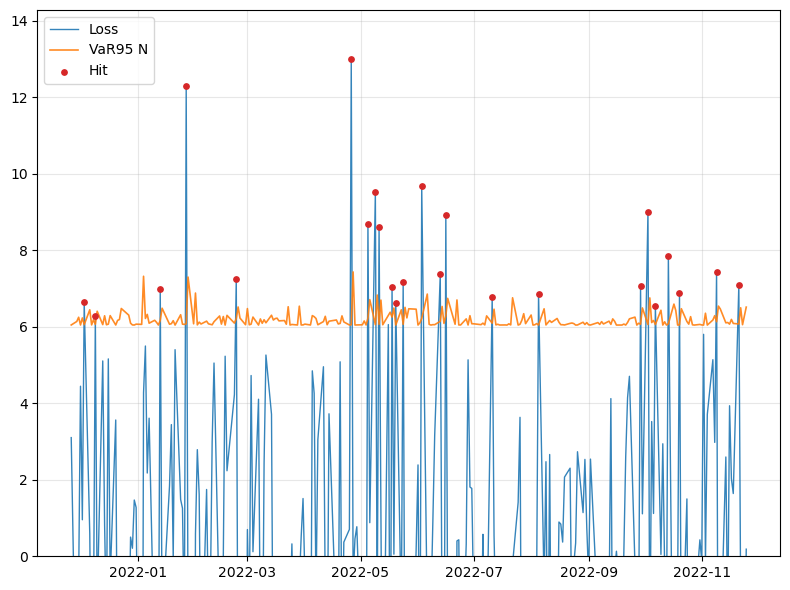

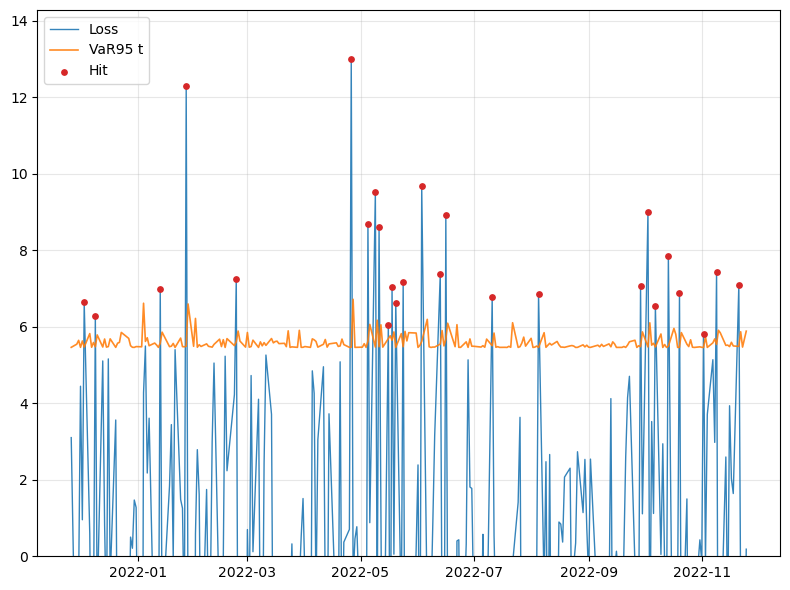

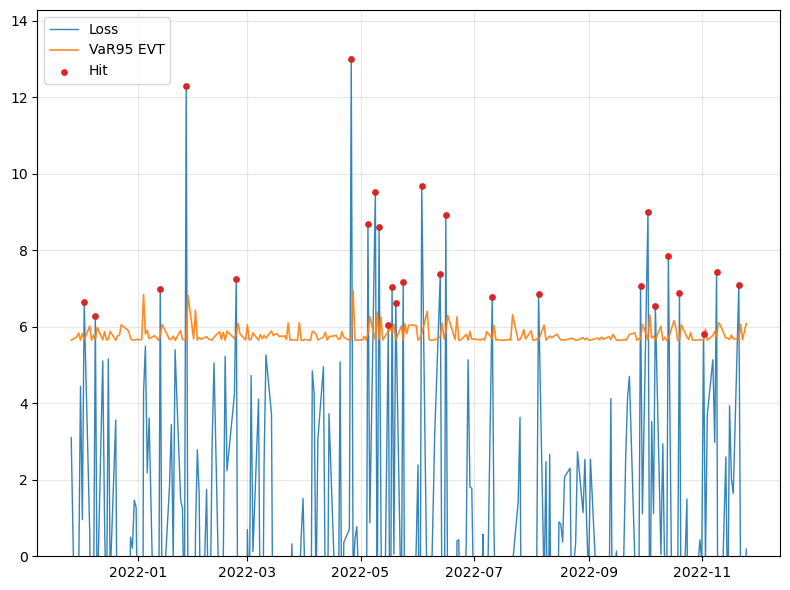

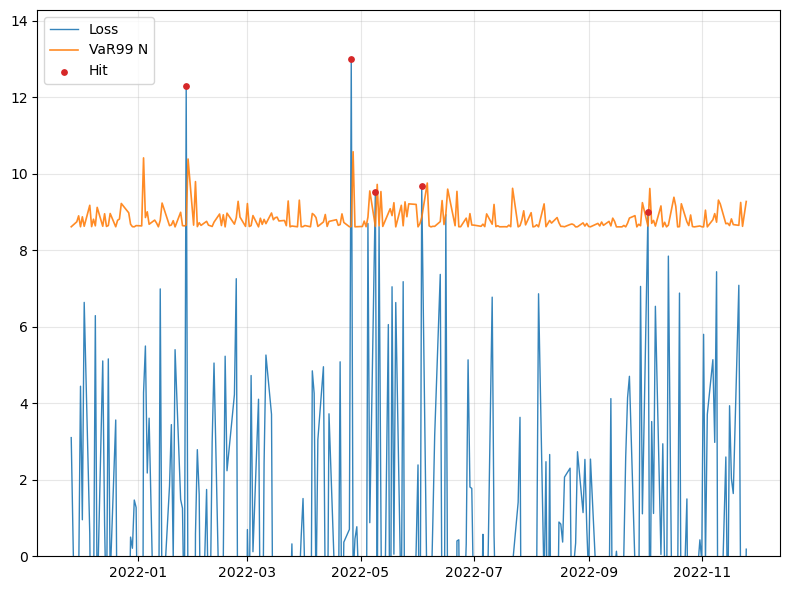

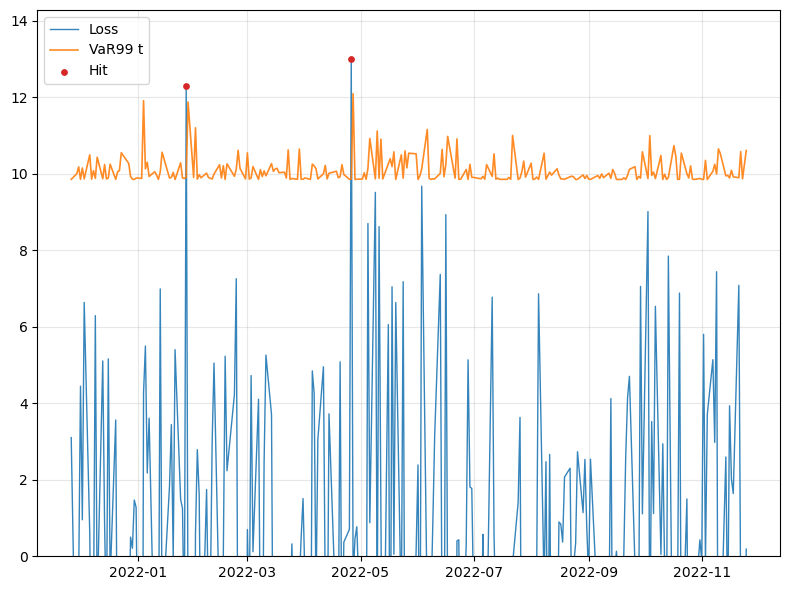

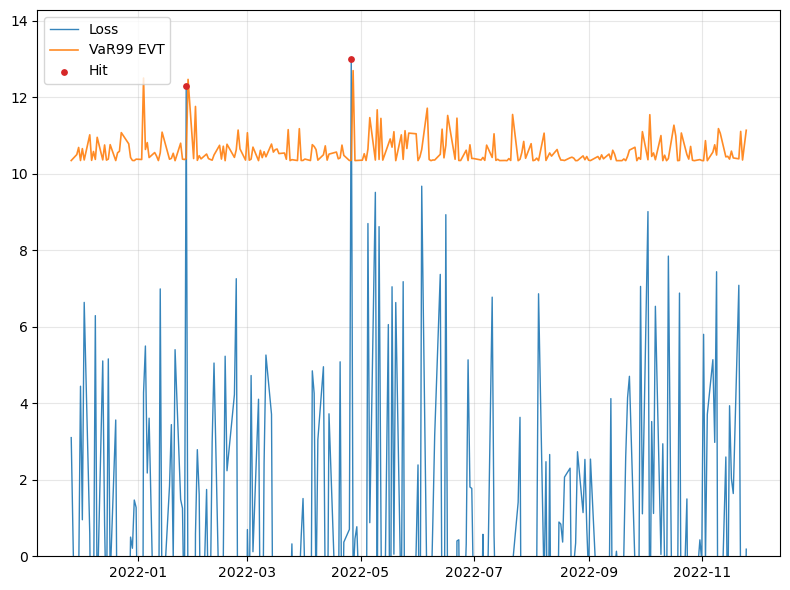

In [34]:
test_df["Date"] = pd.to_datetime(test_df["Date"])

def plot_loss_var(out, level=0.95, spec="N", figsize=(8, 6)):

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    var_col = f"VaR{int(level*100)}_{spec}"
    hits = out["Loss"] > out[var_col]

    ax.plot(test_df["Date"], out["Loss"], lw=1.0, label="Loss", alpha=0.9)
    ax.plot(test_df["Date"], out[var_col],
            lw=1.2, label=f"VaR{int(level*100)} {spec}", alpha=0.9)
    ax.scatter(test_df["Date"][hits],
               out.loc[hits, "Loss"],
               s=15, color="tab:red", label="Hit", zorder=3)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig(f"Assets/Part_iv_{level}_{spec}.png")
    plt.show()

for sp in ("N", "t", "EVT"):
    plot_loss_var(result, level=0.95, spec=sp)

for sp in ("N", "t", "EVT"):
    plot_loss_var(result, level=0.99, spec=sp)

In [35]:
from scipy.stats import chi2

def kupiec_pof_test(hits, p):
    hits = np.asarray(hits).astype(int)
    n = hits.size
    x = hits.sum()
    pi0 = 1.0 - p
    phat = max(min(x / n, 1 - 1e-12), 1e-12)
    L0 = (1 - pi0)**(n - x) * (pi0**x)
    L1 = (1 - phat)**(n - x) * (phat**x)
    LR = -2.0 * np.log(L0 / L1)
    pval = 1 - chi2.cdf(LR, df=1)
    return {"n": n, "x": x, "hit_rate": x/n, "LR": LR, "p_value": pval}

def backtest_table(out):
    rows = []
    for p in (0.95, 0.99):
        for sp in ("N","t","EVT"):
            var_col = f"VaR{int(p*100)}_{sp}"
            hits = (out["Loss"] > out[var_col]).astype(int)
            stat = kupiec_pof_test(hits, p)
            rows.append({
                "level": int(p*100),
                "spec": sp,
                "n": stat["n"],
                "x": stat["x"],
                "hit_rate": stat["hit_rate"],
                "LR_pof": stat["LR"],
                "p_value": stat["p_value"]
            })
    tbl = pd.DataFrame(rows)
    tbl["target_rate"] = 1 - (tbl["level"] / 100.0)
    tbl = tbl.sort_values(["level","spec"]).reset_index(drop=True)
    return tbl

bt = backtest_table(result)
print(bt.to_string(index=False))
summary = bt[["level","spec","hit_rate","target_rate","p_value","LR_pof"]]
print("\n== Coverage summary ==")
print(summary.to_string(index=False))

 level spec   n  x  hit_rate    LR_pof  p_value  target_rate
    95  EVT 252 26  0.103175 11.633227 0.000648         0.05
    95    N 252 24  0.095238  8.680822 0.003216         0.05
    95    t 252 26  0.103175 11.633227 0.000648         0.05
    99  EVT 252  2  0.007937  0.116636 0.732712         0.01
    99    N 252  5  0.019841  1.916525 0.166240         0.01
    99    t 252  2  0.007937  0.116636 0.732712         0.01

== Coverage summary ==
 level spec  hit_rate  target_rate  p_value    LR_pof
    95  EVT  0.103175         0.05 0.000648 11.633227
    95    N  0.095238         0.05 0.003216  8.680822
    95    t  0.103175         0.05 0.000648 11.633227
    99  EVT  0.007937         0.01 0.732712  0.116636
    99    N  0.019841         0.01 0.166240  1.916525
    99    t  0.007937         0.01 0.732712  0.116636


In [36]:
print(nu)
print(u_evt)
print(xi_evt)
print(beta_evt)
print(p_u_evt)

3.799953189361671
1.12
0.06725927314561826
0.7051316934108947
0.08958517210944396


In [37]:
z = np.asarray(norm_std_resid)
z = z[np.isfinite(z)]
p_u = np.mean(z > u)
print(p_u)

0.08958517210944396


From the table above, we see the unconditional coverage (Kupiec POF test) for the 95% and 99% VaR forecasts.

For performance at the 95% level, all three models (Normal, Student-$t$, and EVT) performed poorly, with hit rates ranging between 9.5% and 10.3%. The p-values are effectively zero ($< 0.05$), meaning we strongly reject the null hypothesis that the models are correct.
This collective failure is likely due to regime shift. The models were trained on data prior to Nov 2021 (mostly a bull market). The test set (Nov 2021–Nov 2022) contained the 2022 tech crash, characterised by significantly higher volatility. Because we estimated parameters only once (static estimation) rather than using a rolling window, the GARCH model's "reaction" to the new volatility was constrained by the older parameters.

For performance at the 99% level, the normal model had a hit rate of 1.98% (roughly double the target). While the p-value ($0.16$) does not strictly reject the model due to the small sample size ($N=252$), the hit rate clearly indicates an underestimation of extreme risk. This confirms that the Normal distribution assumption is too thin-tailed for TSLA returns. Borh student-$t$ and EVT models achieved a hit rate of 0.79% (2 hits out of 252 days), which is very close to the expected 1%. The p-values ($0.73$) are high, indicating a failure to reject the null hypothesis.

### Conclusion

The Student-$t$ and EVT specifications significantly outperformed the Normal distribution at the 99% level. By accounting for heavy tails (via degrees of freedom $\nu \approx 3.8$ or shape $\xi \approx 0.09$), these models provided adequate capital protection against extreme events, even though the volatility calibration was imperfect. For this dataset, the Student-$t$ specification is the most efficient choice; it provides similar performance to EVT at the 99% level but is simpler to implement (fewer parameters to tune compared to the threshold selection in EVT).